In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time #helper libraries

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation, Dropout

from sklearn.metrics import mean_squared_error
from math import sqrt

from tensorflow.keras.models import model_from_json

In [2]:
# file is downloaded from finance.yahoo.com, 1.1.1997-1.1.2017
# training data = 1.1.1997 - 1.1.2007
# test data = 1.1.2007 - 1.1.2017
input_file="DAT_MT_EURUSD_M1_2005-2019.csv"

In [3]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# fix random seed for reproducibility
np.random.seed(5)

In [4]:
# load the dataset
df = read_csv(input_file, header=None, index_col=None, delimiter=',')

In [5]:
# take close price column[5]
all_y = df[5].values
dataset=all_y.reshape(-1, 1)
dataset

array([[1.3555 ],
       [1.3466 ],
       [1.3468 ],
       ...,
       [1.12105],
       [1.12099],
       [1.12076]])

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.56396523],
       [0.54833611],
       [0.54868733],
       ...,
       [0.15225217],
       [0.15214681],
       [0.15174291]])

In [7]:
# split into train and test sets, 50% test data, 50% training data
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [ ]:
train

In [ ]:
test

In [8]:
# reshape into X=t and Y=t+1, timestep 240
look_back = 110
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX

In [ ]:
trainY

In [9]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
trainX

In [12]:
# create and fit the LSTM network, optimizer=adam, 25 neurons, dropout 0.1
model = Sequential()
model.add(LSTM(400, input_shape=(1, look_back)))
model.add(Dropout(0.025))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#

In [10]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [11]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [12]:
loaded_model.compile(loss='mse', optimizer='adam')

In [13]:
loaded_model.fit(trainX, trainY, epochs=36, batch_size=500, verbose=1)

Train on 4245830 samples
Epoch 1/36
4245830/4245830 [==============================] - 372s 88us/sample - loss: 6.3686e-06
Epoch 2/36
4245830/4245830 [==============================] - 369s 87us/sample - loss: 6.3780e-06
Epoch 3/36
4245830/4245830 [==============================] - 368s 87us/sample - loss: 6.3456e-06
Epoch 4/36
4245830/4245830 [==============================] - 370s 87us/sample - loss: 6.3488e-06
Epoch 5/36
4245830/4245830 [==============================] - 370s 87us/sample - loss: 6.3822e-06
Epoch 6/36
4245830/4245830 [==============================] - 369s 87us/sample - loss: 6.2774e-06
Epoch 7/36
4245830/4245830 [==============================] - 370s 87us/sample - loss: 6.3139e-06
Epoch 8/36
4245830/4245830 [==============================] - 373s 88us/sample - loss: 6.2368e-06
Epoch 9/36
4245830/4245830 [==============================] - 373s 88us/sample - loss: 6.2230e-06
Epoch 10/36
4245830/4245830 [==============================] - 376s 89us/sample - loss: 6.278

In [15]:
# make predictions
trainPredict = loaded_model.predict(trainX)
testPredict = loaded_model.predict(testX)

In [ ]:
trainPredict

In [ ]:
testPredict

In [16]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainY

In [ ]:
testY

In [17]:
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))*1000
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:,0]))*1000
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.43 RMSE
Test Score: 0.42 RMSE


In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot = trainPredict

In [ ]:
trainPredict

In [ ]:
trainPredictPlot

testPrices:
testPredictions:
[[1.0568467]
 [1.0568464]
 [1.0568745]
 ...
 [1.1207987]
 [1.1207728]
 [1.1207248]]


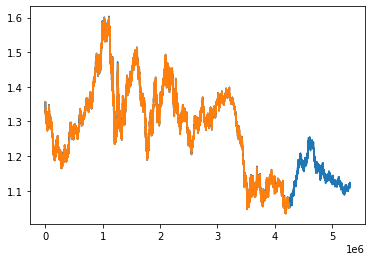

In [19]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

print('testPredictions:')
print(testPredict)

In [20]:
# shift train predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot = testPredict

testPrices:
testPredictions:
[[1.0568467]
 [1.0568464]
 [1.0568745]
 ...
 [1.1207987]
 [1.1207728]
 [1.1207248]]


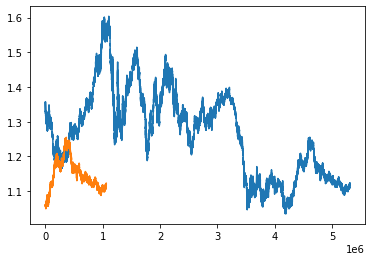

In [21]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(testPredictPlot)
print('testPrices:')
testPrices=scaler.inverse_transform(dataset[test_size+look_back:])

print('testPredictions:')
print(testPredict)

In [22]:
np.savetxt("predict.csv", testPredict, delimiter=",") 

In [23]:
# serialize model to JSON
model_json = loaded_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [24]:
# serialize weights to HDF5
loaded_model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
